In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [ ]:
# Load the dataset
df = pd.read_csv('customer_segmentation.csv', encoding='ISO-8859-1')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Data Cleaning
df.dropna(subset=['CustomerID'], inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [ ]:
# Calculate RFM metrics
now = datetime(2011, 12, 10)  # One day after the last transaction
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,2,0.00
1,12347,39,171,4085.18
2,12348,75,31,1797.24
3,12350,310,17,334.40
4,12352,36,95,1545.41


In [ ]:
# Calculate RFM score
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=False) + 1
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=False) + 1
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=False) + 1
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)


In [ ]:
# Define RFM labels
def rfm_label(row):
    if row['RFM_Score'] == '555':
        return 'Best Customers'
    elif row['RFM_Score'][0] == '5':
        return 'Loyal Customers'
    elif row['RFM_Score'][2] == '5':
        return 'Big Spenders'
    elif row['RFM_Score'][0] == '1':
        return 'Lost Customers'
    elif row['RFM_Score'][2] == '1':
        return 'Low Spenders'
    else:
        return 'Other'

rfm['RFM_Label'] = rfm.apply(rfm_label, axis=1)

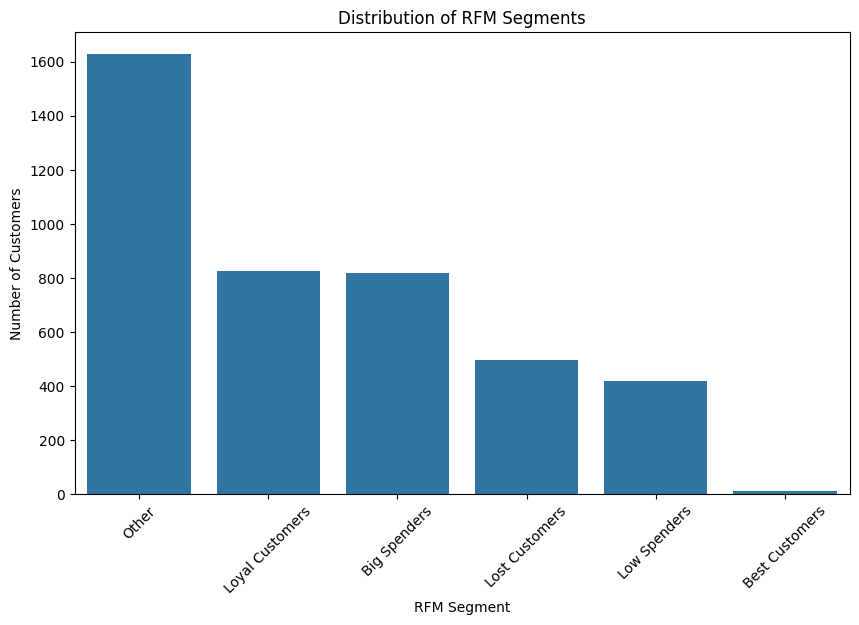

In [ ]:
# Convert RFM_Label to a categorical type to avoid errors
rfm['RFM_Label'] = pd.Categorical(rfm['RFM_Label'])

# 1. Distribution of RFM Segments
plt.figure(figsize=(10, 6))
sns.countplot(x='RFM_Label', data=rfm, order=rfm['RFM_Label'].value_counts().index)
plt.title('Distribution of RFM Segments')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


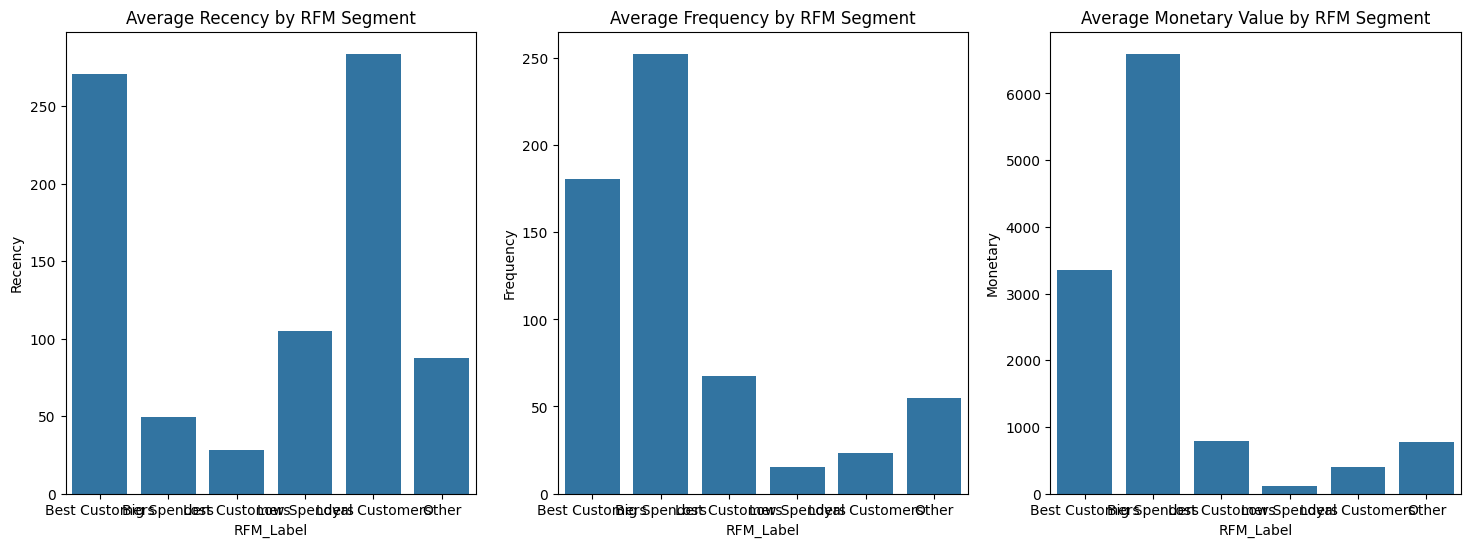

In [ ]:
# 2. Average Recency, Frequency, and Monetary Value by RFM Segment
rfm_means = rfm.groupby('RFM_Label').mean()[['Recency', 'Frequency', 'Monetary']].reset_index()

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(x='RFM_Label', y='Recency', data=rfm_means, ax=ax[0])
ax[0].set_title('Average Recency by RFM Segment')
sns.barplot(x='RFM_Label', y='Frequency', data=rfm_means, ax=ax[1])
ax[1].set_title('Average Frequency by RFM Segment')
sns.barplot(x='RFM_Label', y='Monetary', data=rfm_means, ax=ax[2])
ax[2].set_title('Average Monetary Value by RFM Segment')
plt.show()

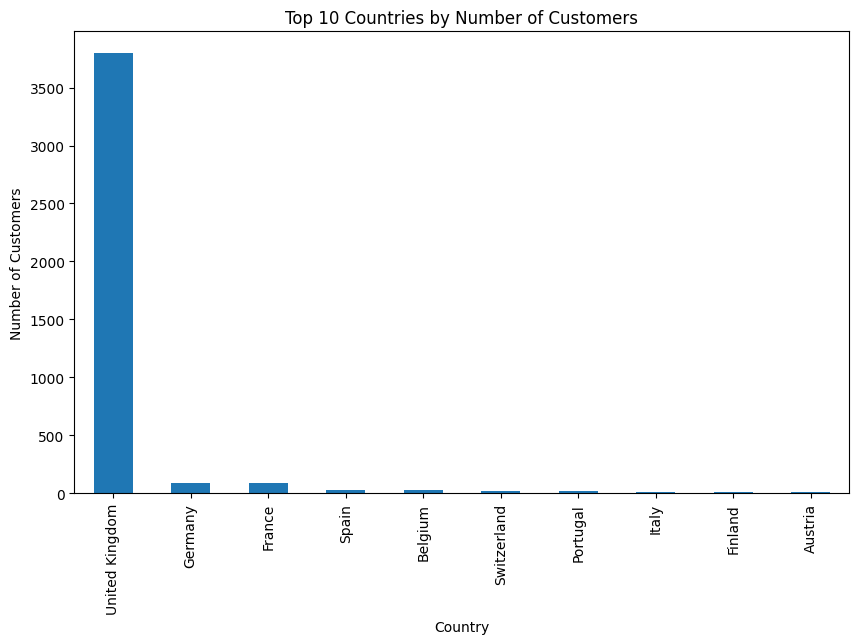

In [ ]:
# 3. Customer Distribution by Country
country_distribution = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
country_distribution.plot(kind='bar')
plt.title('Top 10 Countries by Number of Customers')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.show()

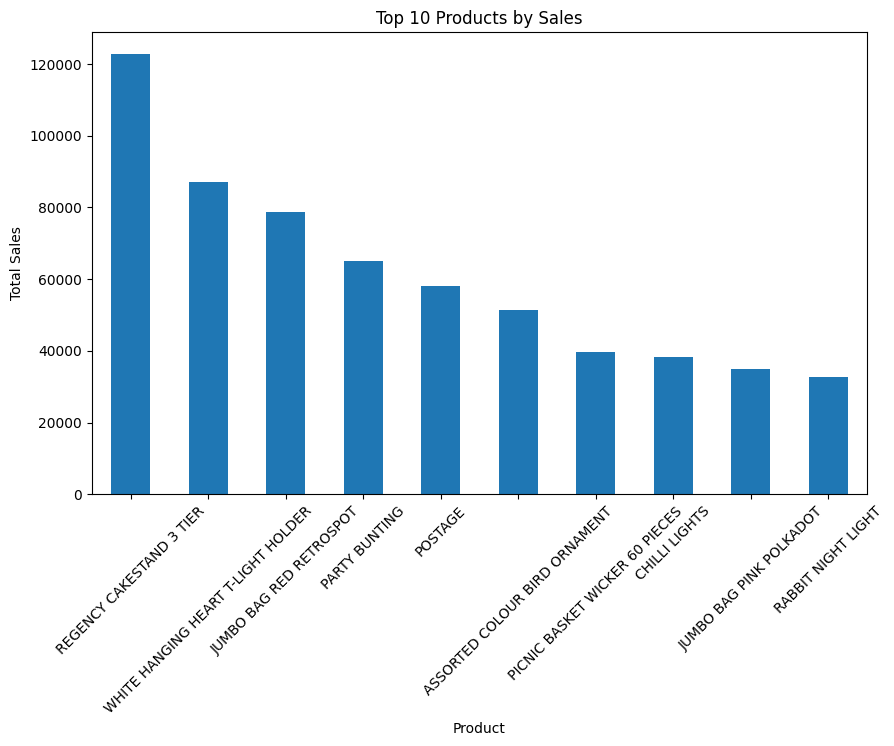

In [ ]:
# 4. Top Products by Sales
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_products.plot(kind='bar')
plt.title('Top 10 Products by Sales')
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

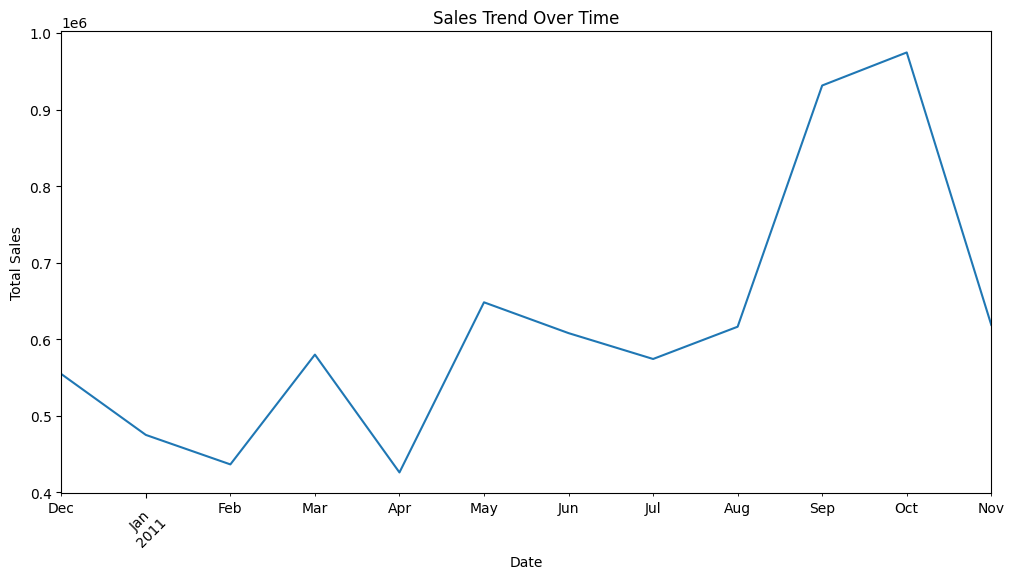

In [ ]:
# 5. Sales Trend Over Time
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')
sales_trend = df.groupby('MonthYear')['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
sales_trend.plot(kind='line')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Customer profiling
profile = rfm.groupby('RFM_Label').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

profile.columns = ['Customer Segment', 'Number of Customers', 'Average Recency', 'Average Frequency', 'Average Monetary Value']

# Displaying the profile dataframe as a table
display(profile.style.format({
    'Average Recency': '{:.1f}',
    'Average Frequency': '{:.1f}',
    'Average Monetary Value': '{:.2f}'
}))

,Customer Segment,Number of Customers,Average Recency,Average Frequency,Average Monetary Value
0,Best Customers,11,270.9,180.6,3346.54
1,Big Spenders,817,49.7,252.5,6597.73
2,Lost Customers,497,28.0,67.6,788.72
3,Low Spenders,417,105.2,15.5,117.81
4,Loyal Customers,827,284.0,23.1,391.50
5,Other,1628,87.8,54.9,768.94


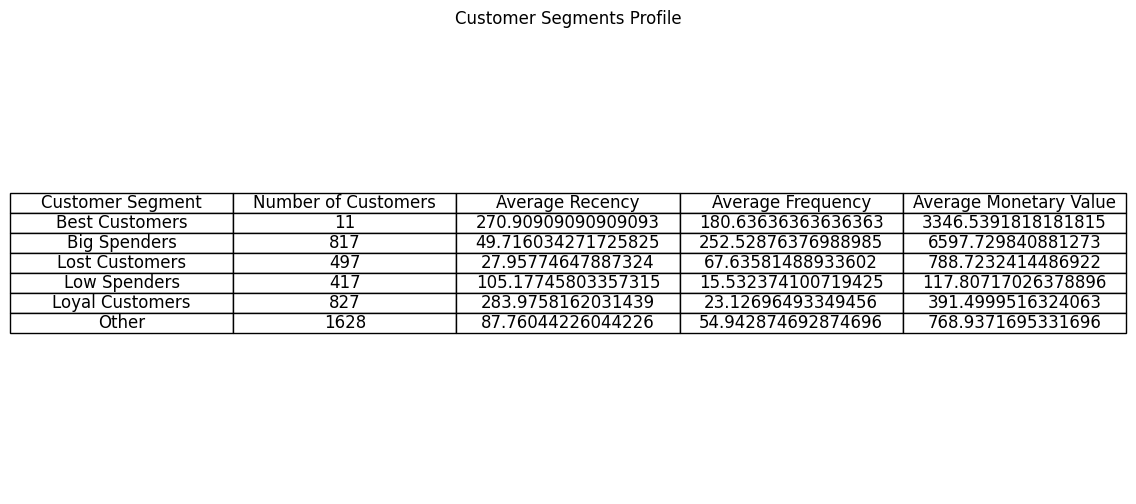

In [ ]:
# Creating the table visualization
fig, ax = plt.subplots(figsize=(12, 6))  # set size frame
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=profile.values, colLabels=profile.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.title('Customer Segments Profile')
plt.show()